In [35]:
import numpy as np
import nibabel as nib

In [36]:
#!spec2nii dicom -f sub-05-metab /Users/jacekdmochowski/PROJECTS/fus/data/bold/sub-05/mrs/WIP_859K_svs_edit_MOD

#!spec2nii dicom -f /Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/mathai_active /Users/jacekdmochowski/PROJECTS/fus/data/scanner_data/MATHAI/ACTIVE/WIP_859K_svs_edit_MOD

!spec2nii dicom -f /Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/lin_active.nii /Users/jacekdmochowski/PROJECTS/fus/data/scanner_data/LIN/ACTIVE/func-wip_task-pre

/Users/jacekdmochowski/fsl/lib/python3.10/site-packages/spec2nii/Siemens/dicomfunctions.py:10: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  import nibabel.nicom.dicomwrappers
Found 3 files.


## Here I am reading in the nifti file from spec2nii

In [46]:
#
path_to_nii = '/Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/mathai_active.nii'
nii = nib.load(path_to_nii)

## Here I am reading in the contents of the nifti file

In [47]:
# get the data and keep complex numbers
data = nii.get_fdata(dtype=np.complex64)

In [48]:
data = np.squeeze(data)
data.shape

(512, 3)

/Users/jacekdmochowski/miniconda3/envs/fus/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jacekdmochowski/miniconda3/envs/fus/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


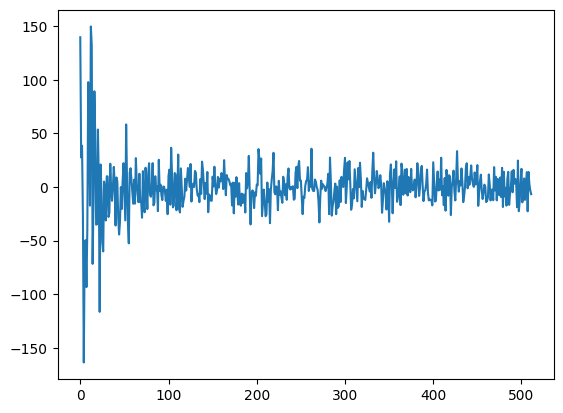

In [49]:
# plot power spectrum
import matplotlib.pyplot as plt
plt.plot(data[:,2])
#plt.xlim([0,100])

In [50]:
fid = data[:,2]

# compute the power spectrum
power = np.abs(np.fft.fft(fid))**2

(0.0, 3000.0)

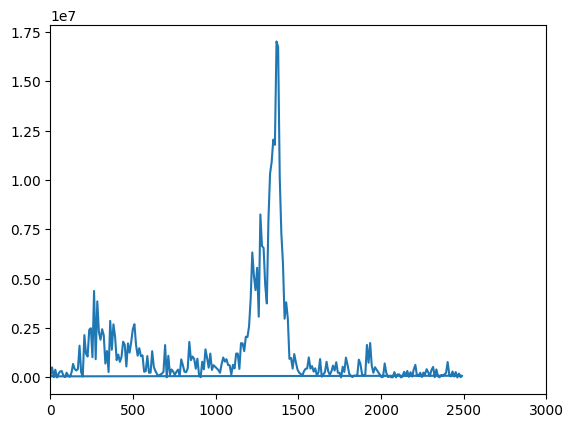

In [51]:
# plot power spectrum
import matplotlib.pyplot as plt
freqs = np.fft.fftfreq(len(fid),1/5000)
plt.plot(freqs,power)
plt.xlim([0,3000])

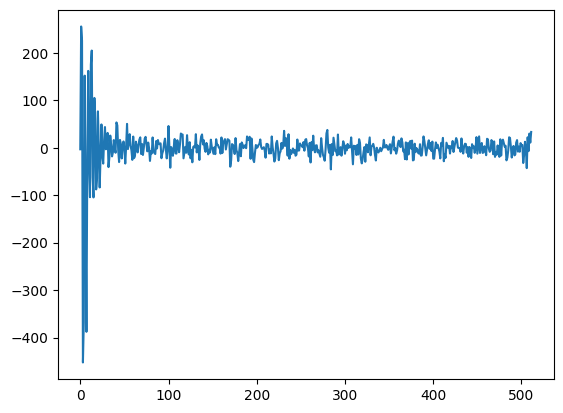

In [9]:
# plot the spectrum
import matplotlib.pyplot as plt

In [7]:
import numpy as np
data = np.squeeze(data)


In [8]:
data.shape

(2048,)

In [9]:
# perform fft
data_fft = np.fft.fft(data)

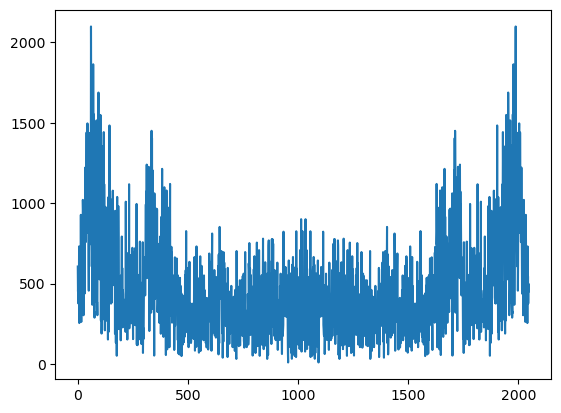

In [11]:
# plot magnitude
plt.plot(np.abs(data_fft))